In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.metrics import mean_squared_error

import ml_helpers as mlh

from random_forest import plot_actual_vs_predicted as pavp

import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import ANN

/Users/evanmiller/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

def teach_the_terminator(train_features, 
                         train_labels,
                        ml_method):
    
    if ml_method == "Ordinary Least Squares":
        reg = linear_model.LinearRegression()
    if ml_method == "Ridge Regression":
        reg = linear_model.Ridge()
    if ml_method == "Bayesian Regression":
        reg = linear_model.BayesianRidge()
    if ml_method == "Support Vector Machine":
        reg = SVR(kernel='rbf', max_iter = 1000)
    if ml_method == "Stochastic Gradient Descent":
        reg = linear_model.SGDRegressor()
    if ml_method == "K-Nearest Neighbors":
        reg = KNeighborsRegressor()
    if ml_method == "Random Forest":
        reg = RandomForestRegressor()
    if ml_method == "Gradient Boosting":
        reg = GradientBoostingRegressor()
    reg.fit(train_features, train_labels)
    return reg

In [3]:
def run_net(train, 
            test, 
        Nlayers = 3, 
        N_nodes= [10, 5, 1], 
        training_iterations = 1e3, 
        run_name = "", 
        show_comparison = False, 
        nfilters = 27,
        convolution_outsize = 10,
        forward_hops_only = False):

    train_features = train.drop(['chromophoreA', 'chromophoreB', 'TI'], axis=1)
    test_features = test.drop(['chromophoreA', 'chromophoreB', 'TI'], axis=1)
    train_labels = train[['TI']]
    test_labels = test[['TI']]
    test_answers = test_labels
    
    train_features, test_features, train_labels, test_labels = train_features.values, test_features.values, train_labels.values, test_labels.values

    assert Nlayers == len(N_nodes)

    x = tf.placeholder(tf.float32, shape = [None, len(train_features[0])])
    y_ = tf.placeholder(tf.float32, shape = [None, 1])

    layer_dict = {}

    xconv = ANN.convolve(x, nfilters, convolution_outsize)

    for N in range(Nlayers):
        if N == 0:
            layer_dict["layer_{}".format(N)] = tf.nn.elu(ANN.weights(x, convolution_outsize, N_nodes[N]))
        elif N + 1 == Nlayers:
            layer_dict["layer_{}".format(N)] = tf.nn.elu(ANN.weights(layer_dict["layer_{}".format(N-1)], N_nodes[N-1], N_nodes[N]))
        else:
            layer_dict["layer_{}".format(N)] = tf.nn.elu(ANN.weights(layer_dict["layer_{}".format(N-1)], N_nodes[N-1], N_nodes[N]))

    y_out = layer_dict["layer_{}".format(Nlayers-1)]

    cost = tf.losses.huber_loss(labels = y_, predictions = y_out)
    #cost = tf.losses.mean_squared_error(labels = y_, predictions = y_out)

    #training_step = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

    optimizer = tf.train.AdamOptimizer(0.01)
    training_step = optimizer.minimize(cost)

    session = tf.Session()
    session.run(tf.global_variables_initializer())

    #saver = tf.train.Saver()

    training_error = []

    for _ in range(int(training_iterations)):
        batch_vectors, batch_answers = ANN.get_batch(train_features, train_labels)
        session.run(training_step,feed_dict={x:batch_vectors,y_:batch_answers})
        if _ % (int(training_iterations)//10) == 0:

            train_error = session.run(cost,feed_dict={x:train_features,y_:train_labels})
            training_error.append([_, train_error])
            print(train_error)

    pred_y = session.run(y_out, feed_dict={x: test_features})

    #rmse = session.run(cost,feed_dict={x:test_features,y_:test_labels})
    mae = np.mean(abs(pred_y-test_labels))

    slope, intercept, r_value, p_value, std_err = stats.linregress(
        test_labels.flatten(), pred_y.flatten()
    )
    print(pred_y.shape, test_labels.shape)

    #plot_based_on_density(test_answers, pred_y, "Neural Net", r_value**2, mae)
    return pred_y

In [4]:
def make_plots(actual, predicted, feature, names):
    plt.close()
    colors = feature
    plt.scatter(
        actual, predictions, s=12, alpha=0.5, zorder=0, c=colors, cmap="jet"
    )
    plt.plot(
        np.linspace(0, np.amax(actual), 10),
        np.linspace(0, np.amax(actual), 10),
        c="k",
        zorder=10,
    )
    plt.colorbar()
    plt.ylabel("Predicted TI")
    plt.xlabel("Actual TI")
    plt.title("{}".format(names))
    plt.show()

In [24]:
def analyze_predictions(pred, tests):
    slope, intercept, r_value, p_value, std_err = stats.linregress(tests.values.flatten(), 
                                                                   pred.flatten())
    mae = np.mean(abs(pred.flatten() - tests.values.flatten()))
    return r_value, mae

In [44]:
from matplotlib.colors import LogNorm
from matplotlib import cm

def plot_based_on_density(actual, predicted, system, r_value, mae):
    print("Beginning the Plot.")
    actual = np.array(actual.values).flatten()
    predicted = predicted.flatten()
    
    fig, ax = plt.subplots()
    
    plt.hist2d(actual, predicted, (50, 50), norm=LogNorm(), cmap='viridis')
    plt.colorbar()
    plt.plot(np.linspace(0, np.amax(actual), 10),
            np.linspace(0, np.amax(actual), 10),
            'w--',
            alpha = 0.5)
    plt.xlabel("Actual (eV)")
    plt.ylabel("Predicted (eV)")
    plt.title("{}".format(system))
    plt.text(0.8, 0.1, 
             s=r"R$^{2}$:"+"{:.4f}\nMAE:{:.4f}".format(r_value**2, mae), 
             color = 'w', fontsize = 20)
    rgba = cm.get_cmap('viridis')
    rgba = rgba(0.0)
    ax.set_facecolor(rgba)
    ax.set_xlim([0, np.amax(actual)])
    ax.set_ylim([0, np.amax(predicted)])
    plt.show()
    

In [7]:
#def manual_load(database="p3ht_pdi.db", training_tables=None, validation_tables=None,
#             absolute=None, skip=[], yval="TI"):
#    training_records = []
#    print("".join(["Loading data from ", database, "..."]))
#    # Obtain training tables first:
#    if training_tables is None:
#        # Fetch all tables
#        print("Using all tables to train from...")
#        connection = sqlite3.connect(database)
#        cursor = connection.cursor()
#        query = "SELECT name FROM sqlite_master WHERE type='table';"
#        cursor.execute(query)
#        training_tables = [name[0] for name in cursor.fetchall()]
#        cursor.close()
#        connection.close()
#    for table_name in training_tables:
#        data, all_column_names = mlh.load_table(database, table_name)
#        for record in data:
#            training_records.append(record)
#    column_names_to_use = list(set(all_column_names) - set(skip))
#    train_features, train_labels = mlh.create_data_frames(np.array(training_records),
#                                                      absolute,
#                                                      all_column_names,
#                                                      column_names_to_use,
#                                                      yval)
#    print("Separating training and test data...")
#    if validation_tables is None:
#        # Split the dataset we have to be 95%:5%
#        return train_test_split(train_features, train_labels, test_size=0.05)
#    else:
#        # Need to load the right validation data:
#        validation_records = []
#        for table_name in validation_tables:
#            data, _ = mlh.load_table(database, table_name)
#            for record in data:
#                validation_records.append(record)
#        test_features, test_labels = mlh.create_data_frames(np.array(validation_records),
#                                                        absolute,
#                                                        all_column_names,
#                                                        column_names_to_use,
#                                                        yval)
#
#    test_features.sort_index(axis=1, inplace=True)
#    train_features.sort_index(axis=1, inplace=True)
#
#    return train_features, test_features, train_labels, test_labels

In [15]:
#def apply_machine_method(method_name, results_df, plot_scatter=False):
#
#    df_train = pd.concat([train_features, train_labels], axis=1)
#    df_test = pd.concat([test_features, test_labels], axis=1)
#
#    # Stitch the training and testing data by concatenating along
#    # axis = 0
#    #df = pd.concat([df_train, df_test], axis=0)
#
#    reg = teach_the_terminator(train_features, train_labels, method_name)
#
#    predictions = np.array([reg.predict(test_features)]).T 
#    
#    if len(predictions.shape) == 3:
#        predictions = predictions[0]
#        
#    results_df[method_name] = predictions
#
#    r_value, mae = analyze_predictions(predictions, test_labels)
#
#    plot_based_on_density(test_labels, predictions, method_name, r_value, mae)
#    if plot_scatter:
#        pavp(test_labels, predictions, r_value, mae, name=method_name)
#    
#    del reg
#    
#    return results_df

def apply_combined(method_name, train, test, plot_scatter=False):
    
    train = train.drop(['chromophoreA', 'chromophoreB'], axis=1)
    test = test.drop(['chromophoreA', 'chromophoreB'], axis=1)
    print(list(train.drop('TI', axis=1)))
    
    reg = teach_the_terminator(train.drop(['TI'], axis=1), 
                               train[['TI']], 
                               method_name)
    predictions = np.array([reg.predict(test.drop(['TI'], axis=1)).T])
    
    if len(predictions.shape) == 3:
        predictions = predictions[0]
        
    print(predictions.T.shape, test[['TI']].shape)
    r_value, mae = analyze_predictions(predictions.T, test[['TI']])

    plot_based_on_density(test[['TI']], predictions, method_name, r_value, mae)
    if plot_scatter:
        pavp(test[['TI']], predictions, r_value, mae, name=method_name)
    
    del reg
    return predictions

In [8]:
train_features, test_features, train_labels, test_labels = mlh.get_data(
    database = 'p3ht_pdi.db',
    training_tables=['ordered_frame_0', 
                     'semiordered_frame_0',
                     'disordered_frame_0',
                    ],
    validation_tables=['semiordered_frame_1'],
    absolute=['rotX', 'rotY', 'rotZ'],
    skip=[],
    yval='TI',
)

Loading data from p3ht_pdi.db...
Separating training and test data...


Ordinary Least Squares, Ridge Regression and Bayesian Regression all produce the same predictions.

Using the Support Vector Machine on the complete data set was too slow.

(10-8-18)

Without doing any normalizing and using the built in scikit learn functions, the random forest and K-Nearest neighbors are the only two that give decent regression predictions. Support vector machines start having issues with the large dataset, but can be aleviated by setting a number of max iterations. However, it predicts a high number of actual 0 TIs with about 0.25 predicted TI. However, the bonded peak is fairly close to what's predicted.

In using the KNN and RF, the RF does a better job at fitting the data in that, the bonded atoms have a tail going towards the origin

(10-20-18)

I've split up the training into two portions: ''bonded'' and ''non-bonded''. This still causes some error because while labeled bonded, it is acutally the same chain that is being tested. As such there is likely wrapping that occurs and monomers monomers are neighbors but not actually bonded and should have low TIs. Need to test, actually bonded to verify this.

(10-26-18)

The systems lose the Actual 0 values when the bonded/nonbonded are specified rather than the same chain. So this metric seems to do better. 
The neural net still struggles with the low values of the bonded/non-bonded training.

Need to see if splitting it is what's needed or just having the better metric of same chain vs bonded.

Having bonded and nonbonded combined seems to work just fine for the forest, which still has the best overall results.
The ANN struggles with the small, non-bonded values making it less favorable. K-nearest works okay, but doesn't get the shape of the distribution as well as the forest. 

When running the forest on the externally curated data there is a difference from what's seen here (There are quite a few low predicted, acutal high values). So I'm going to trim the notebook and rerun it to see if memory not being cleared is contributing to the issue.

['bonded', 'deltaE', 'distance', 'posX', 'posY', 'posZ', 'rotX', 'rotY', 'rotZ', 'sulfur_distance']
(241222, 1) (241222, 1)
Beginning the Plot.


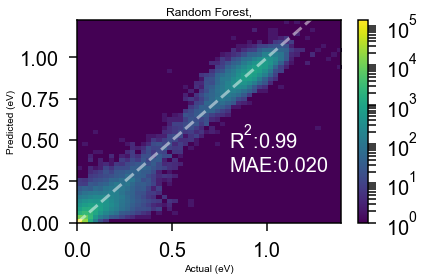

CPU times: user 2min 32s, sys: 1.88 s, total: 2min 34s
Wall time: 2min 30s


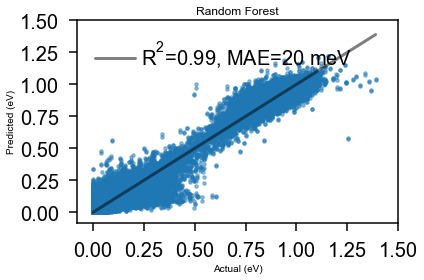

In [10]:
#%time predictions = apply_combined("Random Forest", train_features, test_features, plot_scatter=True)

In [9]:
columns = list(train_features.drop('TI', axis=1))

In [12]:
#for column in columns:
#    make_plots(test_labels.values.flatten(), 
#               predictions.flatten(),
#              test_features[[column]].values.flatten(),
#              column)

In [13]:
#train = pd.concat([train_features, train_labels], axis=1)
#test = pd.concat([test_features, test_labels], axis=1)

In [14]:
#train_bonded = train_features.loc[train_features['bonded'] == 1]
#test_bonded = test_features.loc[test_features['bonded'] == 1]
#train_nonbonded = train_features.loc[train_features['bonded'] == 0]
#test_nonbonded = test_features.loc[test_features['bonded'] == 0]

In [15]:
#%time predictions = apply_combined("Random Forest", train_bonded, test_bonded)

In [16]:
#%time predictions = apply_combined("Random Forest", train_nonbonded, test_nonbonded)

In [17]:
#train_features['distance'] = np.sqrt(train_features['posX']**2+train_features['posY']**2+train_features['posZ']**2)
#test_features['distance'] = np.sqrt(test_features['posX']**2+test_features['posY']**2+test_features['posZ']**2)

In [18]:
#%time predictions = apply_combined("Random Forest", train_features, test_features, plot_scatter=True)

In [19]:
#data = pd.concat([train_features, test_features])

In [20]:
#hist = data.hist('sulfur_distance', figsize = (15, 15), bins = 80)
#hist = plt.xticks(np.arange(0, 20))

In [21]:
"""
    if ml_method == "Ordinary Least Squares":
        reg = linear_model.LinearRegression()
    if ml_method == "Ridge Regression":
        reg = linear_model.Ridge()
    if ml_method == "Bayesian Regression":
        reg = linear_model.BayesianRidge()
    if ml_method == "Support Vector Machine":
        reg = SVR(kernel='rbf', max_iter = 1000)
    if ml_method == "Stochastic Gradient Descent":
        reg = linear_model.SGDRegressor()
    if ml_method == "K-Nearest Neighbors":
        reg = KNeighborsRegressor()
    if ml_method == "Random Forest":
        reg = RandomForestRegressor()
    if ml_method == "Gradient Boosting":
    """

'\n    if ml_method == "Ordinary Least Squares":\n        reg = linear_model.LinearRegression()\n    if ml_method == "Ridge Regression":\n        reg = linear_model.Ridge()\n    if ml_method == "Bayesian Regression":\n        reg = linear_model.BayesianRidge()\n    if ml_method == "Support Vector Machine":\n        reg = SVR(kernel=\'rbf\', max_iter = 1000)\n    if ml_method == "Stochastic Gradient Descent":\n        reg = linear_model.SGDRegressor()\n    if ml_method == "K-Nearest Neighbors":\n        reg = KNeighborsRegressor()\n    if ml_method == "Random Forest":\n        reg = RandomForestRegressor()\n    if ml_method == "Gradient Boosting":\n    '

['bonded', 'deltaE', 'distance', 'posX', 'posY', 'posZ', 'rotX', 'rotY', 'rotZ', 'sulfur_distance']
(241222, 1) (241222, 1)
Beginning the Plot.


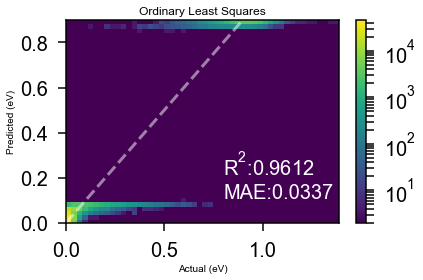

CPU times: user 1.48 s, sys: 490 ms, total: 1.97 s
Wall time: 829 ms


In [48]:
results = test_features[['TI']]
%time predictions = apply_combined("Ordinary Least Squares", train_features, test_features)
results["Ordinary Least Squares"] = predictions.T

['bonded', 'deltaE', 'distance', 'posX', 'posY', 'posZ', 'rotX', 'rotY', 'rotZ', 'sulfur_distance']
(241222, 1) (241222, 1)
Beginning the Plot.


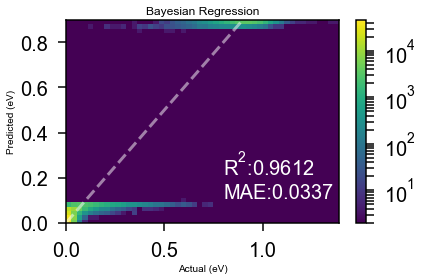

CPU times: user 2.07 s, sys: 599 ms, total: 2.67 s
Wall time: 1.02 s


In [49]:
%time predictions = apply_combined("Bayesian Regression", train_features, test_features)

['bonded', 'deltaE', 'distance', 'posX', 'posY', 'posZ', 'rotX', 'rotY', 'rotZ', 'sulfur_distance']
(241222, 1) (241222, 1)
Beginning the Plot.


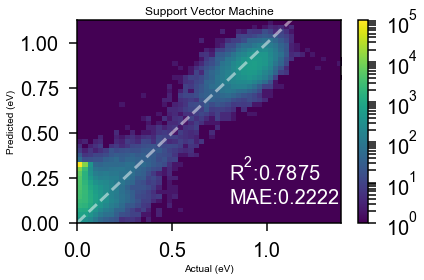

CPU times: user 1min 3s, sys: 677 ms, total: 1min 4s
Wall time: 1min 3s


In [50]:
%time predictions = apply_combined("Support Vector Machine", train_features, test_features)
results["Support Vector Machine"] = predictions.T

['bonded', 'deltaE', 'distance', 'posX', 'posY', 'posZ', 'rotX', 'rotY', 'rotZ', 'sulfur_distance']
(241222, 1) (241222, 1)
Beginning the Plot.


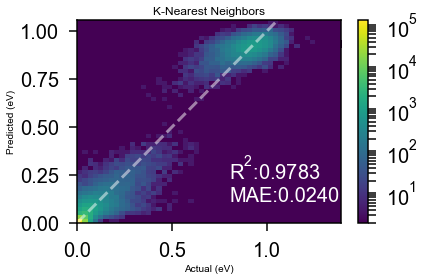

CPU times: user 13.8 s, sys: 443 ms, total: 14.3 s
Wall time: 13 s


In [51]:
%time predictions = apply_combined("K-Nearest Neighbors", train_features, test_features)
results["K-Nearest Neighbors"] = predictions.T

['bonded', 'deltaE', 'distance', 'posX', 'posY', 'posZ', 'rotX', 'rotY', 'rotZ', 'sulfur_distance']
(241222, 1) (241222, 1)
Beginning the Plot.


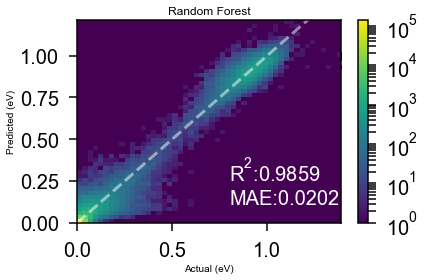

CPU times: user 1min 58s, sys: 1.02 s, total: 1min 59s
Wall time: 1min 56s


In [65]:
%time predictions = apply_combined("Random Forest", train_features, test_features)
results["Random Forest"] = predictions.T

In [66]:
%time predictions = run_net(train_features, test_features, training_iterations = 2e4)
results["Neural Net"] = predictions

8.401637
0.0011008736
0.0008260266
0.00074341556
0.0007382017
0.00077202526
0.00070429035
0.0006780522
0.0006643721
0.0006330035
(241222, 1) (241222, 1)
CPU times: user 6min 47s, sys: 28.8 s, total: 7min 16s
Wall time: 7min 14s


Beginning the Plot.


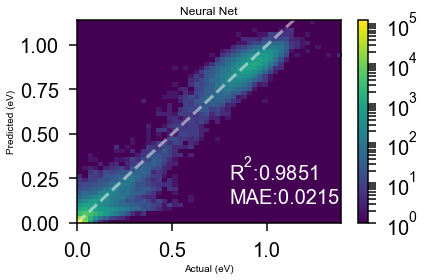

In [67]:
r_value, mae = analyze_predictions(results[['TI']].values, results[['Neural Net']])
plot_based_on_density(results[['TI']], results[['Neural Net']].values, "Neural Net", r_value, mae)

Beginning the Plot.


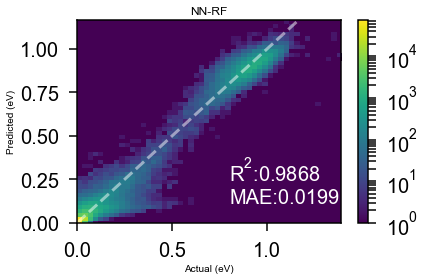

In [68]:
results["NN-RF"] = results[['Neural Net', "Random Forest"]].mean(axis=1)
r_value, mae = analyze_predictions(results[['TI']].values, results[['NN-RF']])
plot_based_on_density(results[['TI']], results[['NN-RF']].values, "NN-RF", r_value, mae)

In [64]:
#results.to_hdf('ml_methods.h5', "results")

In [70]:
#results.to_csv('ml_methods.csv')

In [69]:
results

,TI,Ordinary Least Squares,Support Vector Machine,K-Nearest Neighbors,Random Forest,Neural Net,NN-RF
0,0.000000,0.038071,0.318614,0.014247,0.009980,0.012760,0.011370
1,0.000000,0.002461,0.319222,0.018859,0.012590,0.009989,0.011289
2,0.000000,-0.009954,0.319812,0.010701,0.003926,0.005826,0.004876
3,0.061466,0.042674,0.311536,0.019905,0.007869,0.015852,0.011861
4,0.000000,0.046544,0.284258,0.028534,0.032171,0.023147,0.027659
5,0.000000,0.037111,0.285290,0.015497,0.018715,0.018628,0.018672
6,0.000000,-0.006276,0.319425,0.016353,0.006929,0.008298,0.007614
7,0.951507,0.894231,0.910765,0.963204,0.928830,0.945818,0.937324
8,0.000000,0.016437,0.318004,0.015297,0.008813,0.011387,0.010100
9,0.019987,0.065464,0.238314,0.040479,0.026215,0.037291,0.031753
